## Comparaison des méthodes d'optimisation (GD et variantes)
---
L'objectif est de  comparer différentes méthodes d'optimisation basées sur la descente de gradient ainsi que la méthode de Newton pour minimiser une fonction de coût, comme la régression logistique, sur un ensemble de données. Le projet consisterait à :

- Implémenter différentes variantes de la descente de gradient et Newton, telles que :
    - Descente de gradient standard (Batch Gradient Descent, BGD)
    - Descente de gradient stochastique (Stochastic Gradient Descent, SGD)
    - Descente de gradient par mini-lots (Mini-Batch Gradient Descent)
    - Descente de gradient avec momentum
    - Newton
- Comparaison des Méthodes
Comparer les performances des différentes méthodes d'optimisation sur les mêmes jeux de données (2 jeux différents). Les critères de comparaison peuvent inclure :

    - Le nombre d'itérations nécessaires pour atteindre la convergence.
    - Le coût final atteint par la fonction de coût.
    - La précision finale sur l'ensemble de test.
      
- Analyse de la Sensibilité aux Hyperparamètres
    - Taux d'Apprentissage : Étudiez l'impact de différents taux d'apprentissage sur la vitesse de convergence et la qualité de la solution obtenue.
    - Taille du Mini-Lot (pour Mini-Batch GD) : Testez différentes tailles de mini-lots pour voir leur effet sur la stabilité des mises à jour et la convergence.
    - Facteurs de Momentum (β pour Momentum) : Analysez comment les valeurs de ces hyperparamètres affectent les performances.

Jinyu Cong
Furkan Narin

In [ ]:
# Notebook Python: Comparaison des différentes variantes de la descente de gradient
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, load_breast_cancer

In [ ]:
# IRIS (simplifié à 2 classes)
X_iris, y_iris = load_iris(return_X_y=True)
mask = y_iris != 2           # on garde seulement les classes 0 et 1
X_iris, y_iris = X_iris[mask], y_iris[mask]
y_iris = y_iris.reshape(-1, 1)

# BREAST CANCER
cancer = load_breast_cancer()
X_cancer, y_cancer = cancer.data, cancer.target
y_cancer = y_cancer.reshape(-1, 1)

# Normalisation
scaler = StandardScaler()
X_iris = scaler.fit_transform(X_iris)
X_cancer = scaler.fit_transform(X_cancer)

# Division en train/test
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(X_cancer, y_cancer, test_size=0.2, random_state=42)

X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)

In [ ]:
# Fonction sigmoïde
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Fonction de coût pour la régression logistique
def compute_cost(X, y, theta):
    m = len(y)
    h = sigmoid(X.dot(theta))
    epsilon = 1e-5  # Pour éviter log(0)
    cost = (1/m) * (-y.T.dot(np.log(h + epsilon)) - (1 - y).T.dot(np.log(1 - h + epsilon)))
    return cost[0][0]

# Fonction pour calculer le gradient
def compute_gradient(X, y, theta):
    m = len(y)
    h = sigmoid(X.dot(theta))
    gradient = (1/m) * X.T.dot(h - y)
    return gradient

In [ ]:
class EarlyStopping:
    def __init__(self, previous_cost=np.inf, patience=10, delta=1e-4):
        self.patience = patience
        self.delta = delta
        self.previous_cost = previous_cost
        self.patience_counter = 0
        self.early_stop = False

    def __call__(self, cost):
        if self.previous_cost - cost < self.delta:
            self.patience_counter += 1

        if self.patience_counter > self.patience:
            self.early_stop = True

        self.previous_cost = cost

# Implémentation des différentes variantes de descente de gradient
class GradientDescentVariants:
    def __init__(self, X, y, learning_rate=0.01, iterations=1000, batch_size=None, momentum=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.batch_size = batch_size
        self.momentum = momentum
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.theta = np.zeros((X.shape[1], 1))  # Initialisation des paramètres

    def batch_gradient_descent(self):
        """Descente de Gradient Standard"""
        cost_history = []
        theta = self.theta.copy()
        ep = EarlyStopping()
        for i in range(self.iterations):
            gradient = compute_gradient(self.X, self.y, theta)
            theta -= self.learning_rate * gradient
            cost = compute_cost(self.X, self.y, theta)
            ep(cost)
            if ep.early_stop:
                break
            cost_history.append(cost)
        return theta, cost_history

    def stochastic_gradient_descent(self):
        """Descente de Gradient Stochastique"""
        cost_history = []
        theta = self.theta.copy()
        ep = EarlyStopping()
        for i in range(self.iterations):
            for j in range(len(self.y)):
                random_index = np.random.randint(0, len(self.y))
                X_i = self.X[random_index, :].reshape(1, -1)
                y_i = self.y[random_index].reshape(1, -1)
                gradient = compute_gradient(X_i, y_i, theta)
                theta -= self.learning_rate * gradient
            cost = compute_cost(self.X, self.y, theta)
            ep(cost)
            if ep.early_stop:
                break
            cost_history.append(cost)
        return theta, cost_history

    def mini_batch_gradient_descent(self):
        """Descente de Gradient par Mini-lots"""
        cost_history = []
        theta = self.theta.copy()
        ep = EarlyStopping()
        for i in range(self.iterations):
            indices = np.random.permutation(len(self.y))
            X_shuffled = self.X[indices]
            y_shuffled = self.y[indices]
            for j in range(0, len(self.y), self.batch_size):
                X_i = X_shuffled[j:j+self.batch_size]
                y_i = y_shuffled[j:j+self.batch_size]
                gradient = compute_gradient(X_i, y_i, theta)
                theta -= self.learning_rate * gradient
            cost = compute_cost(self.X, self.y, theta)
            ep(cost)
            if ep.early_stop:
                break
            cost_history.append(cost)
        return theta, cost_history

    def gradient_descent_with_momentum(self):
        """Descente de Gradient avec Momentum"""
        cost_history = []
        theta = self.theta.copy()
        ep = EarlyStopping()
        v = np.zeros_like(theta)  # Vitesse initiale
        for i in range(self.iterations):
            gradient = compute_gradient(self.X, self.y, theta)
            v = self.momentum * v + self.learning_rate * gradient
            theta -= v
            cost = compute_cost(self.X, self.y, theta)
            ep(cost)
            if ep.early_stop:
                break
            cost_history.append(cost)
        return theta, cost_history

    def nesterov_accelerated_gradient(self):
        """Nesterov Accelerated Gradient"""
        cost_history = []
        theta = self.theta.copy()
        ep = EarlyStopping()
        v = np.zeros_like(theta)
        for i in range(self.iterations):
            temp_theta = theta - self.momentum * v
            gradient = compute_gradient(self.X, self.y, temp_theta)
            v = self.momentum * v + self.learning_rate * gradient
            theta -= v
            cost = compute_cost(self.X, self.y, theta)
            ep(cost)
            if ep.early_stop:
                break
            cost_history.append(cost)
        return theta, cost_history

    def adagrad(self):
        """Adagrad"""
        cost_history = []
        theta = self.theta.copy()
        ep = EarlyStopping()
        G = np.zeros_like(theta)
        for i in range(self.iterations):
            gradient = compute_gradient(self.X, self.y, theta)
            G += gradient**2
            adjusted_lr = self.learning_rate / (np.sqrt(G) + self.epsilon)
            theta -= adjusted_lr * gradient
            cost = compute_cost(self.X, self.y, theta)
            ep(cost)
            if ep.early_stop:
                break
            cost_history.append(cost)
        return theta, cost_history

    def rmsprop(self):
        """RMSprop"""
        cost_history = []
        theta = self.theta.copy()
        ep = EarlyStopping()
        E = np.zeros_like(theta)
        for i in range(self.iterations):
            gradient = compute_gradient(self.X, self.y, theta)
            E = self.beta2 * E + (1 - self.beta2) * gradient**2
            adjusted_lr = self.learning_rate / (np.sqrt(E) + self.epsilon)
            theta -= adjusted_lr * gradient
            cost = compute_cost(self.X, self.y, theta)
            ep(cost)
            if ep.early_stop:
                break
            cost_history.append(cost)
        return theta, cost_history

    def adam(self):
        """Adam (Adaptive Moment Estimation)"""
        cost_history = []
        theta = self.theta.copy()
        ep = EarlyStopping()
        m = np.zeros_like(theta)
        v = np.zeros_like(theta)
        for i in range(1, self.iterations + 1):
            gradient = compute_gradient(self.X, self.y, theta)
            m = self.beta1 * m + (1 - self.beta1) * gradient
            v = self.beta2 * v + (1 - self.beta2) * gradient**2
            m_hat = m / (1 - self.beta1**i)
            v_hat = v / (1 - self.beta2**i)
            theta -= self.learning_rate / (np.sqrt(v_hat) + self.epsilon) * m_hat
            cost = compute_cost(self.X, self.y, theta)
            ep(cost)
            if ep.early_stop:
                break
            cost_history.append(cost)
        return theta, cost_history

-------------cancer-------------
Précision pour la méthode Batch Gradient Descent: 0.9737
Précision pour la méthode Stochastic Gradient Descent: 0.9912
Précision pour la méthode Mini-Batch Gradient Descent: 0.9825
Précision pour la méthode Momentum: 0.9737
Précision pour la méthode Nesterov: 0.9737
Précision pour la méthode Adagrad: 0.9825
Précision pour la méthode RMSprop: 0.9912
Précision pour la méthode Adam: 0.9912


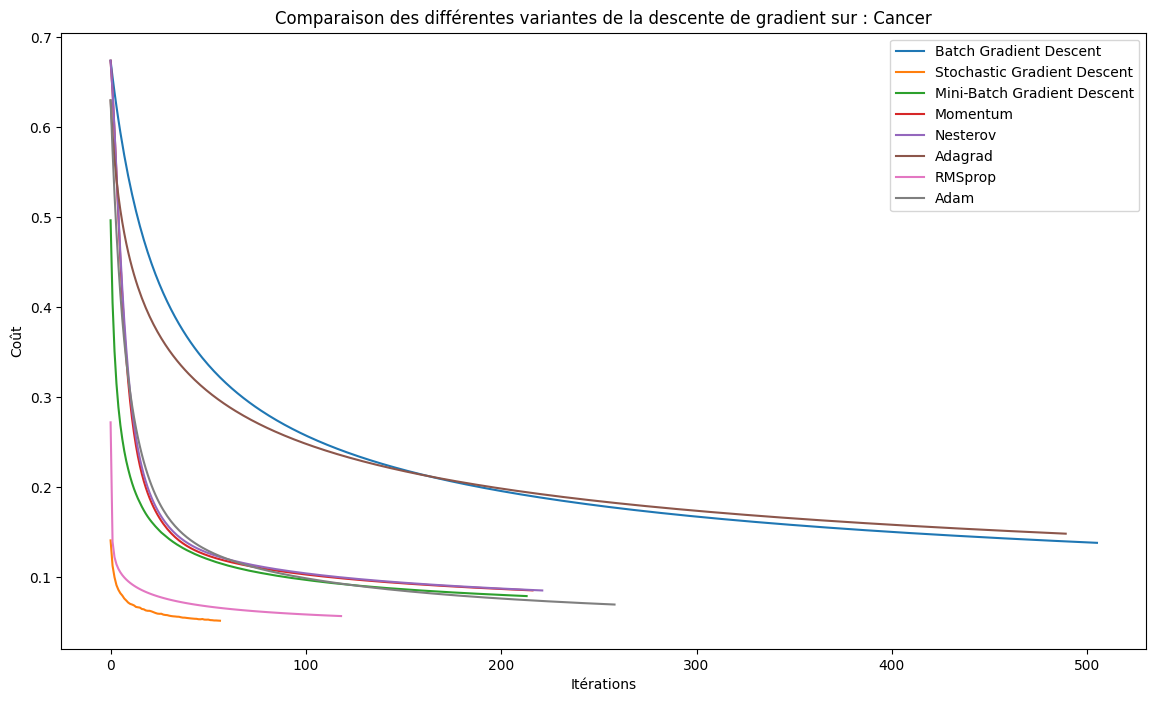

-------------iris-------------
Précision pour la méthode Batch Gradient Descent: 1.0000
Précision pour la méthode Stochastic Gradient Descent: 1.0000
Précision pour la méthode Mini-Batch Gradient Descent: 1.0000
Précision pour la méthode Momentum: 1.0000
Précision pour la méthode Nesterov: 1.0000
Précision pour la méthode Adagrad: 1.0000
Précision pour la méthode RMSprop: 1.0000
Précision pour la méthode Adam: 1.0000


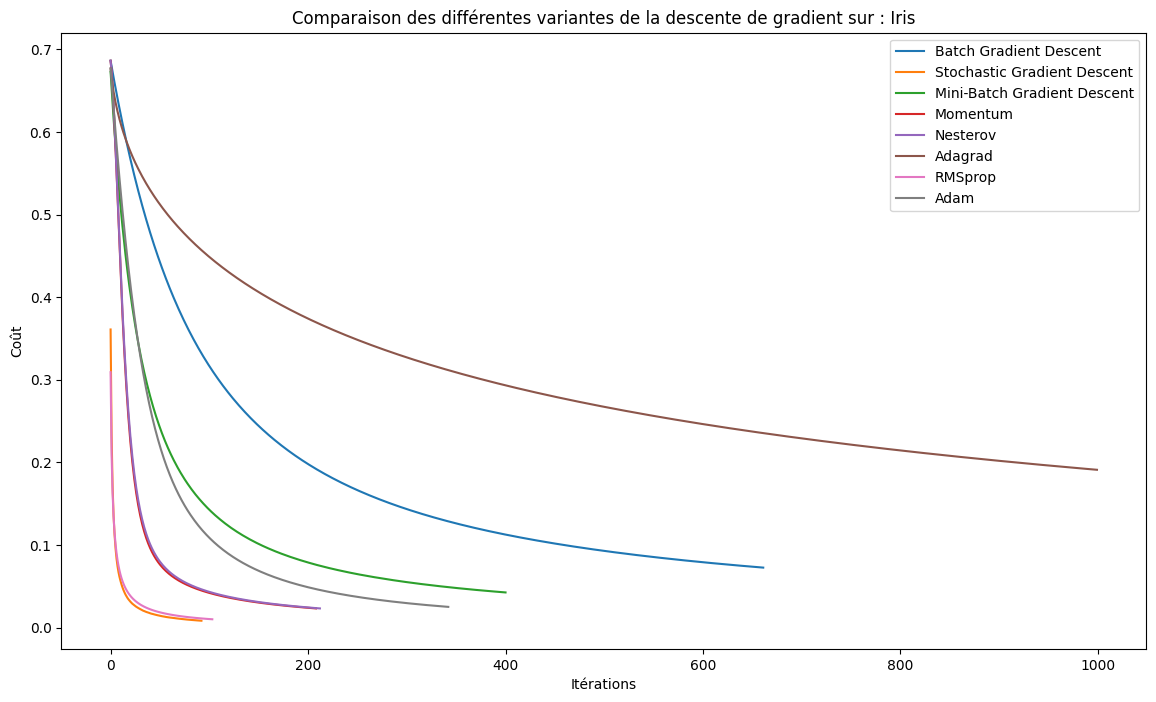

In [ ]:
# Comparaison des méthodes d'optimisation

print("-------------cancer-------------")

gd_variants = GradientDescentVariants(X_train_cancer, y_train_cancer, learning_rate=0.01, iterations=1000, batch_size=32)
methods = {
    'Batch Gradient Descent': gd_variants.batch_gradient_descent,
    'Stochastic Gradient Descent': gd_variants.stochastic_gradient_descent,
    'Mini-Batch Gradient Descent': gd_variants.mini_batch_gradient_descent,
    'Momentum': gd_variants.gradient_descent_with_momentum,
    'Nesterov': gd_variants.nesterov_accelerated_gradient,
    'Adagrad': gd_variants.adagrad,
    'RMSprop': gd_variants.rmsprop,
    'Adam': gd_variants.adam
}

plt.figure(figsize=(14, 8))
for name, method in methods.items():
    theta, cost_history = method()
    prediction = sigmoid(np.dot(X_test_cancer, theta)) > 0.5
    prediction = prediction.astype(int)
    precision = (prediction == y_test_cancer).sum() / len(y_test_cancer)
    print(f'Précision pour la méthode {name}: {precision:.4f}')
    plt.plot(cost_history, label=name)

plt.xlabel('Itérations')
plt.ylabel('Coût')
plt.title('Comparaison des différentes variantes de la descente de gradient sur : Cancer')
plt.legend()
plt.show()


print("-------------iris-------------")

gd_variants = GradientDescentVariants(X_train_iris, y_train_iris, learning_rate=0.01, iterations=1000, batch_size=32)
methods = {
    'Batch Gradient Descent': gd_variants.batch_gradient_descent,
    'Stochastic Gradient Descent': gd_variants.stochastic_gradient_descent,
    'Mini-Batch Gradient Descent': gd_variants.mini_batch_gradient_descent,
    'Momentum': gd_variants.gradient_descent_with_momentum,
    'Nesterov': gd_variants.nesterov_accelerated_gradient,
    'Adagrad': gd_variants.adagrad,
    'RMSprop': gd_variants.rmsprop,
    'Adam': gd_variants.adam
}

plt.figure(figsize=(14, 8))
for name, method in methods.items():
    theta, cost_history = method()
    prediction = sigmoid(np.dot(X_test_iris, theta)) > 0.5
    prediction = prediction.astype(int)
    precision = (prediction == y_test_iris).sum() / len(y_test_iris)
    print(f'Précision pour la méthode {name}: {precision:.4f}')
    plt.plot(cost_history, label=name)

plt.xlabel('Itérations')
plt.ylabel('Coût')
plt.title('Comparaison des différentes variantes de la descente de gradient sur : Iris')
plt.legend()
plt.show()


Pour le jeu de données Iris, la méthode qui converge le mieux est Stochastic et ensuite RMSprop. La descente de gradient suffit pour avoir une très bonne performance des méthodes.
Le nombre d'itérations nécessaires est environ 150 avec un coût final atteint environ 0,01.
La précision finale est très bonne pour la plupart des méthodes car le jeu de données est petit avec peu de variables et donc facil à apprendre.

Pour le jeu de données Cancer, la méthode qui converge le mieux est encore Stochastic mais de petits zigzags et deuxièmment RMSprop. La descente de gradient performe assez bien.
Le nombre d'itérations nécessaires est environ 200 pour la plupart des méthodes mais la meuilleure convergence de Stochastic prend environ 60 itérations et RMSprop environ 120 itérations.
Le coût final atteint environ 0,05. La précision finale est très bonne pour la plupart des méthodes malgré une séparation au début pour les méthodes .

## Compraison des méthodes BGD, SGD, MiniBGD et Newton
---

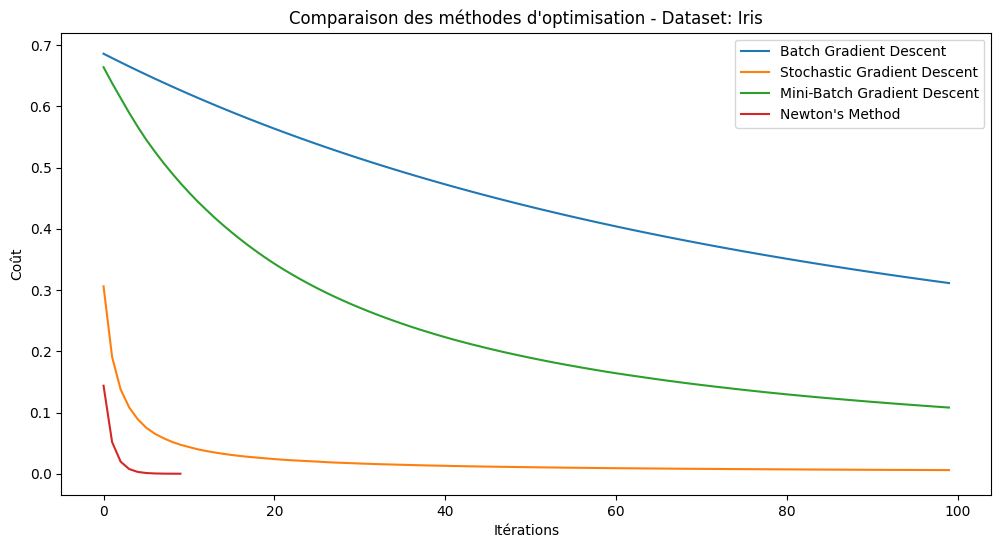

/tmp/ipython-input-1441392570.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


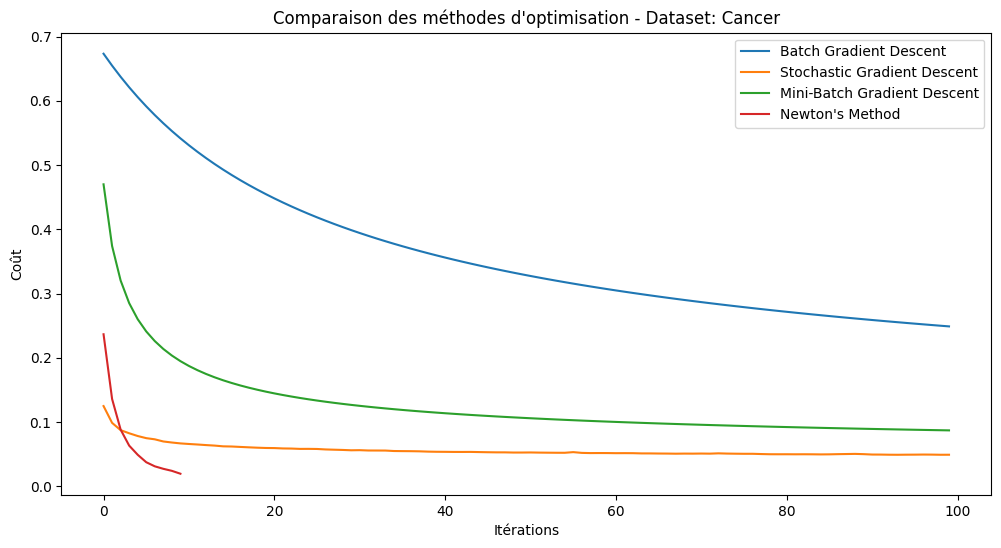

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ======================
# Fonctions de base
# ======================

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_cost(X, y, theta):
    m = len(y)
    predictions = sigmoid(X.dot(theta))
    epsilon = 1e-5  # éviter log(0)
    cost = (1/m) * (-y.T.dot(np.log(predictions + epsilon)) - (1 - y).T.dot(np.log(1 - predictions + epsilon)))
    return cost[0][0]

def logistic_gradient(X, y, theta):
    m = len(y)
    predictions = sigmoid(X.dot(theta))
    gradient = (1/m) * X.T.dot(predictions - y)
    return gradient

def logistic_hessian(X, theta):
    m, n = X.shape
    predictions = sigmoid(X.dot(theta))
    R = np.diag((predictions * (1 - predictions)).flatten())
    H = (1/m) * X.T.dot(R).dot(X)
    return H

# ======================
# Méthodes d'optimisation
# ======================

def newton_method(X, y, iterations=10):
    cost_history = []
    m, n = X.shape
    theta = np.zeros((n, 1))
    for i in range(iterations):
        gradient = logistic_gradient(X, y, theta)
        hessian = logistic_hessian(X, theta)
        H_inv = np.linalg.inv(hessian)
        theta -= H_inv.dot(gradient)
        cost = logistic_cost(X, y, theta)
        cost_history.append(cost)
    return theta, cost_history

def batch_gradient_descent(X, y, learning_rate=0.01, iterations=1000):
    cost_history = []
    m, n = X.shape
    theta = np.zeros((n, 1))
    for i in range(iterations):
        gradient = logistic_gradient(X, y, theta)
        theta -= learning_rate * gradient
        cost = logistic_cost(X, y, theta)
        cost_history.append(cost)
    return theta, cost_history

def stochastic_gradient_descent(X, y, learning_rate=0.01, iterations=1000):
    cost_history = []
    m, n = X.shape
    theta = np.zeros((n, 1))
    for i in range(iterations):
        for j in range(m):
            rand_index = np.random.randint(0, m)
            X_i = X[rand_index, :].reshape(1, -1)
            y_i = y[rand_index].reshape(1, 1)
            gradient = logistic_gradient(X_i, y_i, theta)
            theta -= learning_rate * gradient
        cost = logistic_cost(X, y, theta)
        cost_history.append(cost)
    return theta, cost_history

def mini_batch_gradient_descent(X, y, batch_size=32, learning_rate=0.01, iterations=1000):
    cost_history = []
    m, n = X.shape
    theta = np.zeros((n, 1))
    for i in range(iterations):
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        for j in range(0, m, batch_size):
            X_i = X_shuffled[j:j+batch_size]
            y_i = y_shuffled[j:j+batch_size]
            gradient = logistic_gradient(X_i, y_i, theta)
            theta -= learning_rate * gradient
        cost = logistic_cost(X, y, theta)
        cost_history.append(cost)
    return theta, cost_history

# ======================
# Chargement des datasets
# ======================

def load_dataset(name):
    scaler = StandardScaler()
    if name == "iris":
        X, y = load_iris(return_X_y=True)
        # On garde uniquement deux classes pour rendre le problème binaire (sinon logistic ne marche pas)
        X, y = X[y != 2], y[y != 2]
    elif name == "cancer":
        data = load_breast_cancer()
        X, y = data.data, data.target
    else:
        raise ValueError("Dataset inconnu")

    # Normalisation + biais
    X = scaler.fit_transform(X)
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    y = y.reshape(-1, 1)
    return X, y

# ======================
# Comparaison
# ======================

def compare_methods(dataset_name):
    X, y = load_dataset(dataset_name)

    methods = {
        'Batch Gradient Descent': batch_gradient_descent,
        'Stochastic Gradient Descent': stochastic_gradient_descent,
        'Mini-Batch Gradient Descent': mini_batch_gradient_descent,
        'Newton\'s Method': newton_method
    }

    plt.figure(figsize=(12, 6))
    for name, method in methods.items():
        if name == "Newton's Method":
            _, cost_history = method(X, y, iterations=10)
        else:
            _, cost_history = method(X, y, learning_rate=0.01, iterations=100)
        plt.plot(cost_history, label=name)

    plt.xlabel('Itérations')
    plt.ylabel('Coût')
    plt.title(f'Comparaison des méthodes d\'optimisation - Dataset: {dataset_name.capitalize()}')
    plt.legend()
    plt.show()

# ======================
# Exécution
# ======================

compare_methods("iris")
compare_methods("cancer")


On remarque que la méthode Newton converge beaucoup plus rapidement que les autres et donc est la meuilleure méthode pour les deux jeux de données.

Sur le graphqique du jeu de donnée Iris, la méthode Newton converge très vite avec seulement environ 5 itérations et la méthode Stochastic juste après avec environ 20 itérations.
Le coût atteint avec la méthode Newton est très proche de 0,0 et beaucoup mieux par rapport à Stochastic.
La précision finale reste bien surtout pour Newton et Stochastic mais Batch et Mini Batch performent moins bien.

Sur le graphqique du jeu de donnée Cancer, la méthode Newton converge très vite avec seulement environ 4 itérations et la méthode Stochastic avec moins vite avec environ 100 itérations.
Le coût atteint avec la méthode Newton est très proche de 0,01 et beaucoup mieux par rapport à Stochastic avec environ 0,06.
La précision finale reste bien surtout pour Newton et Stochastic, aussi quand même pour Mini Batch mais Batch performe moins bien.

# Analyse de la Sensibilité aux Hyperparamètres

In [ ]:
lrs = [1e-2, 1e-3, 1e-4, 1e-5]
num_batches = [16, 32, 64, 128]
momentum = [0, 0.5, 0.9, 0.99]
beta1 = [0.8, 0.9, 0.95]
beta2 = [0.99, 0.999, 0.9999]

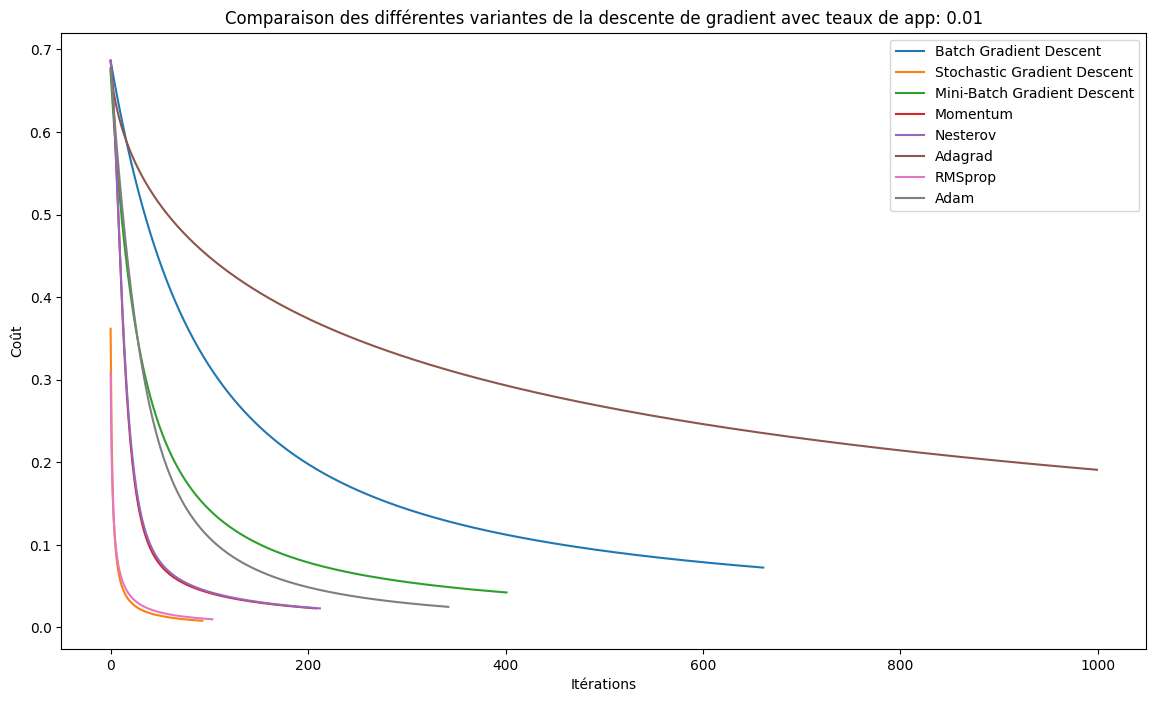

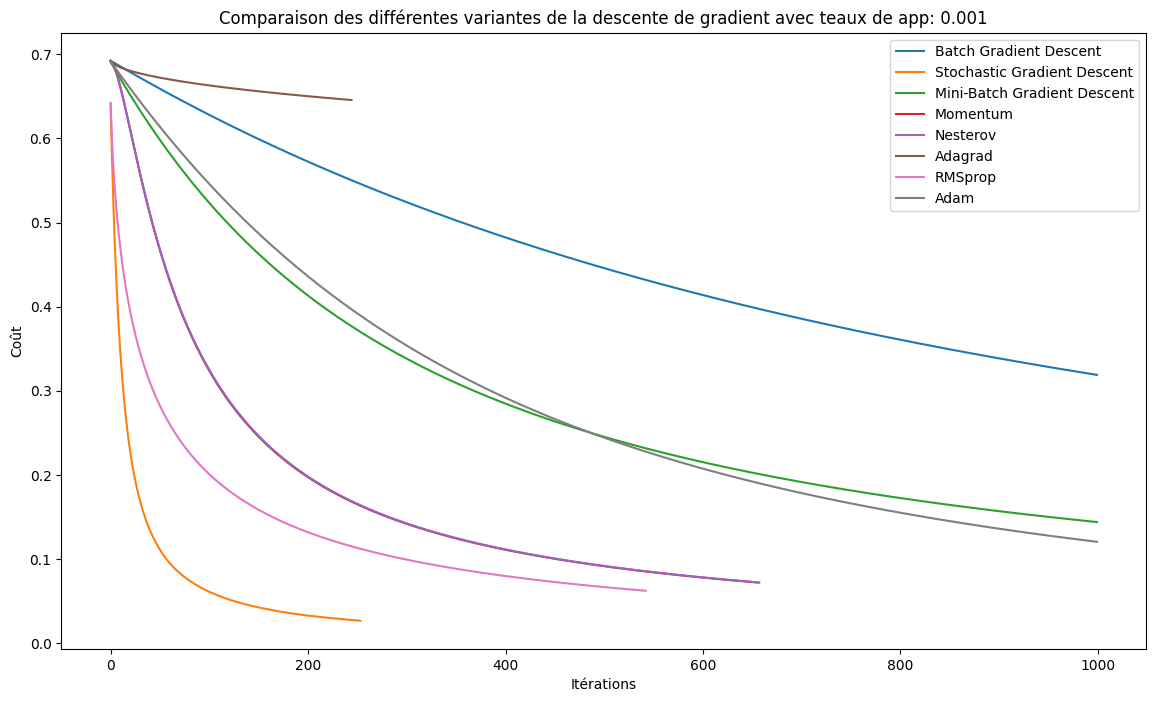

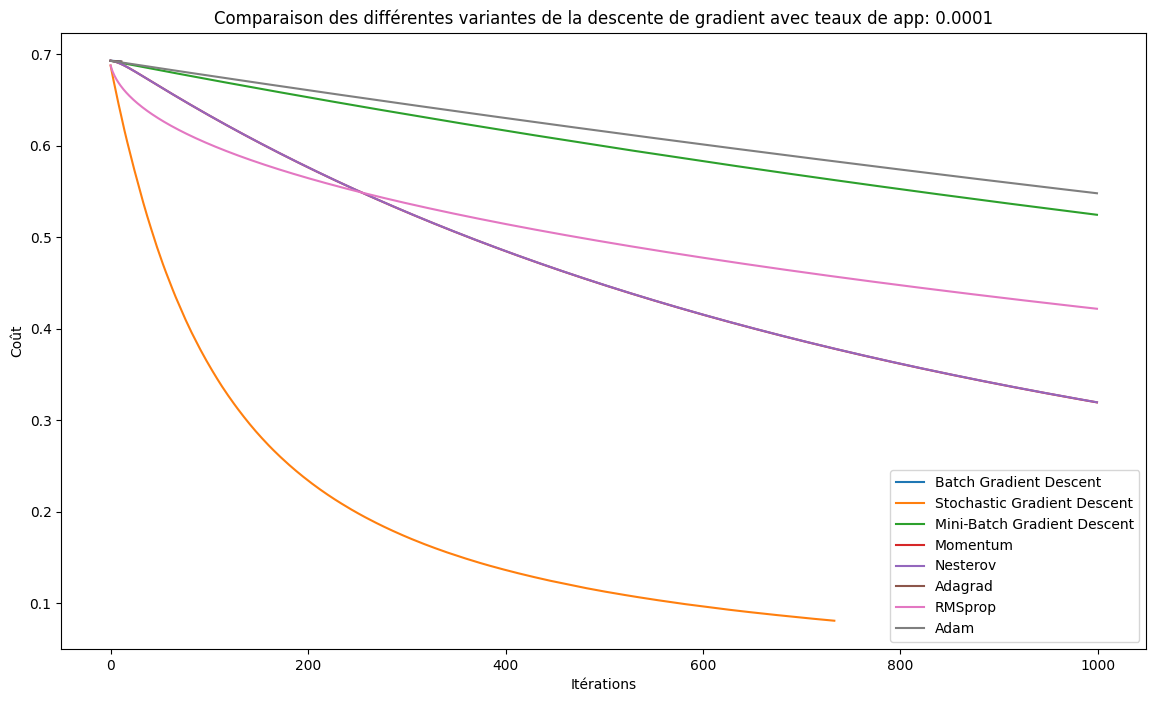

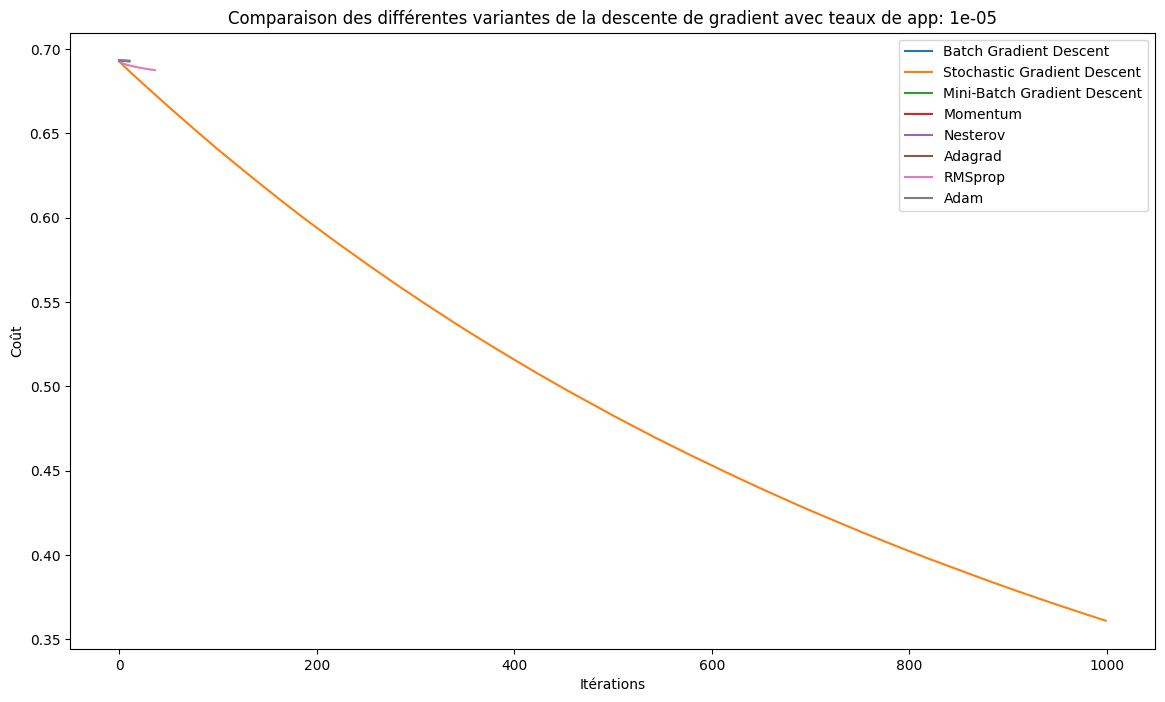

In [ ]:
for lr in lrs:
  gd_variants = GradientDescentVariants(X_train_iris, y_train_iris, learning_rate=lr, iterations=1000, batch_size=32)
  methods = {
    'Batch Gradient Descent': gd_variants.batch_gradient_descent,
    'Stochastic Gradient Descent': gd_variants.stochastic_gradient_descent,
    'Mini-Batch Gradient Descent': gd_variants.mini_batch_gradient_descent,
    'Momentum': gd_variants.gradient_descent_with_momentum,
    'Nesterov': gd_variants.nesterov_accelerated_gradient,
    'Adagrad': gd_variants.adagrad,
    'RMSprop': gd_variants.rmsprop,
    'Adam': gd_variants.adam
  }

  plt.figure(figsize=(14, 8))
  for name, method in methods.items():
      theta, cost_history = method()
      plt.plot(cost_history, label=name)

  plt.xlabel('Itérations')
  plt.ylabel('Coût')
  plt.title(f'Comparaison des différentes variantes de la descente de gradient avec teaux de app: {lr}')
  plt.legend()
  plt.show()


On constate que le meuilleur taux d'apprentissage est 0,01 car la courbe converge rapidemenet et stablement alors que avec les autres taux d'apprentissage, la convergence est plus lente.

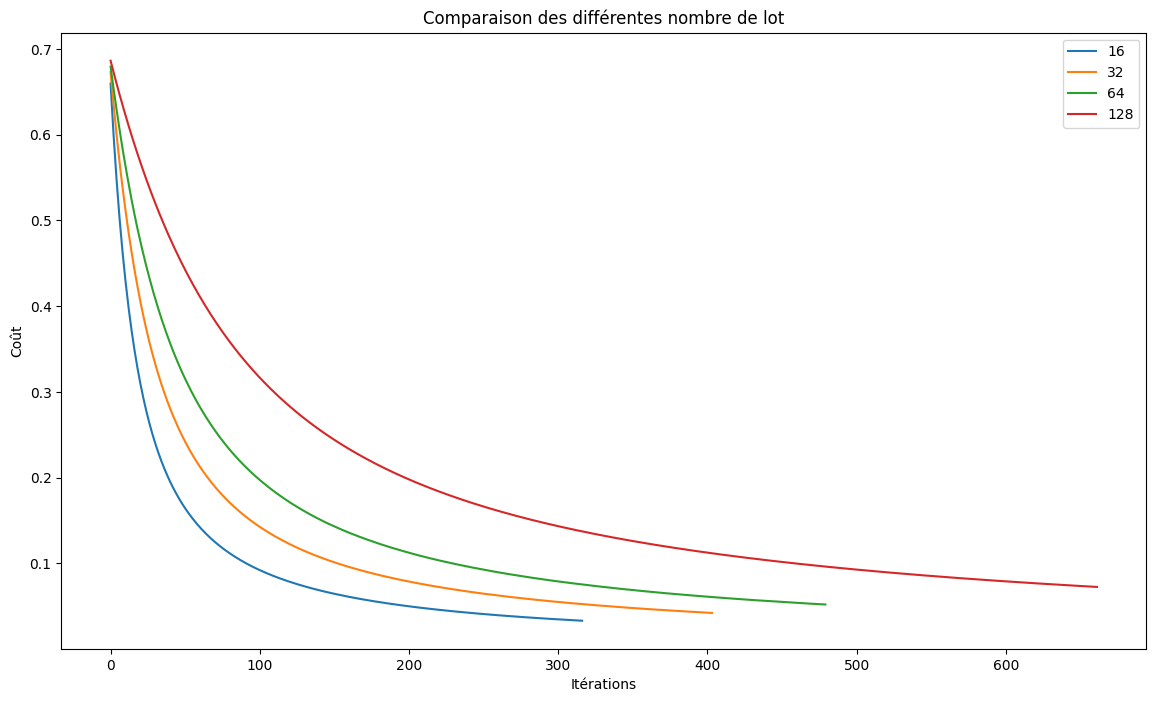

In [ ]:
plt.figure(figsize=(14, 8))
for batch in num_batches:
  gd_variants = GradientDescentVariants(X_train_iris, y_train_iris, learning_rate=0.01, iterations=1000, batch_size=batch)
  theta, cost_history = gd_variants.mini_batch_gradient_descent()
  plt.plot(cost_history, label=batch)

plt.xlabel('Itérations')
plt.ylabel('Coût')
plt.title('Comparaison des différentes nombre de lot')
plt.legend()
plt.show()

Pour la taille du mini-lot, on observe qu’un plus petit lot (comme 16 ou 32) permet une descente du coût plus rapide, indiquant une meilleure réactivité de l’algorithme, tandis qu’un lot plus grand (64 ou 128) rend la convergence plus lente mais plus stable.

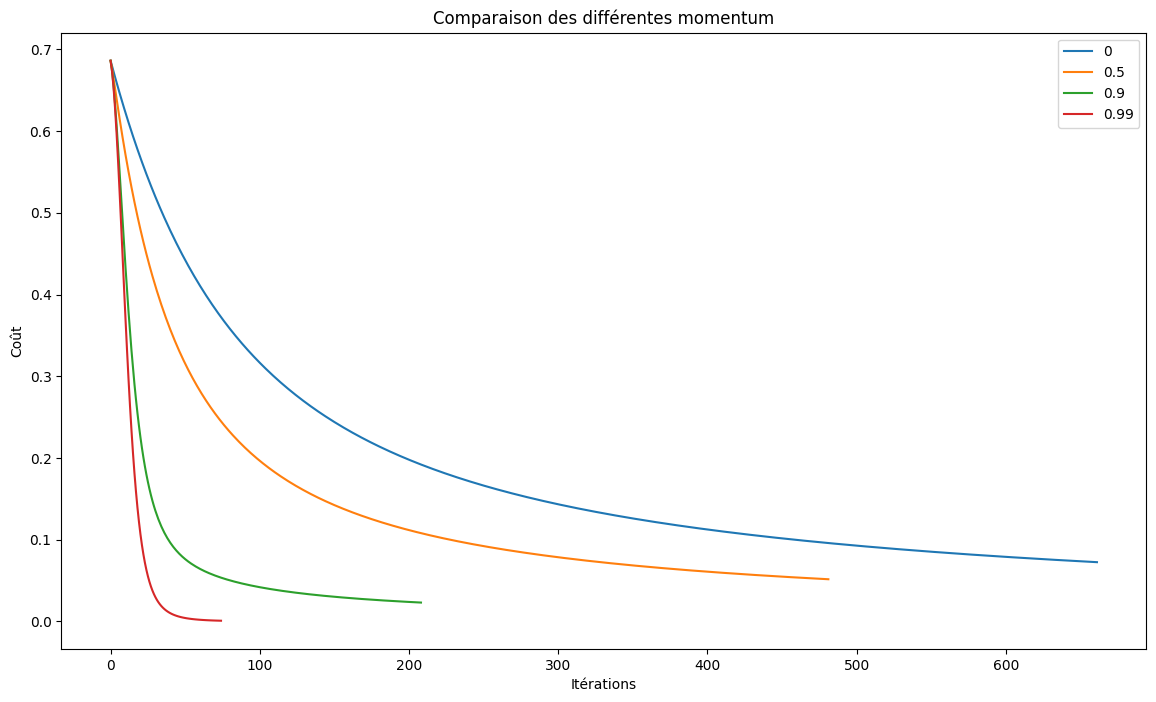

In [ ]:
plt.figure(figsize=(14, 8))
for m in momentum:
  gd_variants = GradientDescentVariants(X_train_iris, y_train_iris, learning_rate=0.01, iterations=1000, batch_size=32, momentum=m)
  theta, cost_history = gd_variants.gradient_descent_with_momentum()
  plt.plot(cost_history, label=m)

plt.xlabel('Itérations')
plt.ylabel('Coût')
plt.title('Comparaison des différentes momentum')
plt.legend()
plt.show()

Concernant le momentum, les courbes montrent que des valeurs élevées (0.9 ou 0.99) accélèrent nettement la convergence et permettent d’atteindre un coût minimal plus rapidement. Ainsi, le choix des hyperparamètres a un impact direct sur la vitesse et la stabilité de l’apprentissage.